<div style='background-image: url("https://www.geophysik.uni-muenchen.de/ROMY/theme/images/ringlaser_wideformat.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: left ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 35% ; height: 150px">
        <div style="position: relative ; top: 50%;  transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%"> <br>ROMY - <br><br>  Synthetic Sagnac Processing </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)"></div>
        </div>
    </div>

## Import 

### Official Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import time

from scipy.signal import resample, hilbert, correlate, decimate, butter, spectrogram, sosfilt, filtfilt, iirnotch
from tqdm import tqdm
from obspy import UTCDateTime, read, read_inventory, Trace
import obspy

### Own Processing Methods

In [2]:
import sys
sys.path.insert(0, 'submodules')

In [3]:
from EchoPerformance import __echo_performance
from CreateSyntheticEventV2 import __create_synthetic_event_v2
from MinimizeResidual import __minimize_residual
from CreateLinearChirp import __create_linear_chirp
from Tapering import __tapering
from InstaFreqHilbert import __insta_freq_hilbert
from Normalize import __normalize
from WriteToMseed import __write_to_mseed
from LoadMseed import __load_mseed
from Modulation import __modulation
from QuerrySeismoData import __querry_seismo_data
from RingLaser import RingLaser


In [4]:
# def third_order_derive(x, pos="MIDDLE"):

#     coeff = np.zeros((5,5))
#     norm = np.array([0,0])
#     sum = 0.

#     norm[0] = 12.;
#     norm[1] = 84.;

#     coeff[0][0] = -125.;
#     coeff[0][1] =  136.;
#     coeff[0][2] =   48.;
#     coeff[0][3] =  -88.;
#     coeff[0][4] =   29.;
#     coeff[1][0] =  -38.;
#     coeff[1][1] =   -2.;
#     coeff[1][2] =   24.;
#     coeff[1][3] =   26.;
#     coeff[1][4] =  -10.;
#     coeff[2][0] =    1.;
#     coeff[2][1] =   -8.;
#     coeff[2][2] =    0.;
#     coeff[2][3] =    8.;
#     coeff[2][4] =   -1.;
#     coeff[3][0] =   10.;
#     coeff[3][1] =  -26.;
#     coeff[3][2] =  -24.;
#     coeff[3][3] =    2.;
#     coeff[3][4] =   38.;
#     coeff[4][0] =  -29.;
#     coeff[4][1] =   88.;
#     coeff[4][2] =  -48.;
#     coeff[4][3] = -136.;
#     coeff[4][4] =  125.;

#     for i in range(0, 5):
#         sum += coeff[pos][i]*x[i];
    
#     if pos == 'MIDDLE':
#         sum /= norm[0];
    
#     else:
#         sum /= norm[1];


#     return sum

In [5]:
from RingLaser import RingLaser

## define G-Ring
G = RingLaser(side=4., form="square", wl=632.8e-9, lat=49.16)

## define ROMY Z-Ring
ROMY_Z = RingLaser(side=11., form="triangle", wl=632.8e-9, lat=49.16)


### Own Plotting Methods

In [6]:
from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from MakeplotTraceAndPSD import __makeplot_trace_and_psd
from MakeplotModulatedSignal import __makeplot_modulated_signal
from MakeplotDemodulationQuality import __makeplot_demodulation_quality


## Configurations

In [7]:

T = 1000

sps = 5000

sgnc = ROMY_Z.get_sagnac_frequency()


modulation_index = ROMY_Z.get_scale_factor()

modulation_scheme = 3


win_type = "flanks"
perc = 5


upsampling_factor = 2

sgnc_is = 553.35

f_lower_bp, f_upper_bp = sgnc_is-5, sgnc_is+5

f_upper_lp = 200

signal = 'real'  ## 'synthetic'  or 'real'


Twindow = 200 # seconds


taper = False

upsampling = False

bandpass_pre = True
lowpass_post = False

normalize = False
remove_median = True


## Read synthetic

In [8]:
import pickle

if signal == 'synthetic':

    name = 'eigenmodes'  # 'model_greece' (greece), 'model_lowperiod' (kermadec 0.001-0.1 Hz), 'car' (1.0-10.0 Hz), 'eigenmodes' (0.003-0.03 Hz)
    
    ifile = open(f'/home/andbro/notebooks/Sagnac_processing/data/{name}.syn',"rb")

    synthetic_signal = pickle.load(ifile)
    timeline = np.arange(0, T+1/sps, 1/sps)
    
    ifile = open(f'/home/andbro/notebooks/Sagnac_processing/data/{name}.mod',"rb")
        
    modeltrace = pickle.load(ifile)
    time_modeltrace = np.arange(0, T+1/sps, 1/sps)
    
    synthetic_signal.size, timeline.size, modeltrace.size, time_modeltrace.size

## Read raw real

In [9]:
from andbro__querrySeismoData import __querrySeismoData

## kermadec
# tbeg = UTCDateTime("2021-03-04 18:45")
# tend = UTCDateTime("2021-03-04 18:45")+T

## greece
tbeg = UTCDateTime("2021-03-03 10:18")
tend = UTCDateTime("2021-03-03 10:18")+T


In [10]:
if signal == 'real':
    
    # st = read('/home/andbro/Documents/ROMY/data/BW.DROMY..FJZ.D.2021.049', 
    #          starttime=UTCDateTime("2021-02-18 15:00"),
    #          endtime=UTCDateTime("2021-02-18 15:00")+T,
    #          )

    st = obspy.read(f"/home/andbro/notebooks/Sagnac_processing/data/event_T{T}.mseed")

#     st, inv = __querrySeismoData(    
#                                 seed_id='BW.DROMY..FJZ',
#                                 starttime=tbeg,
#                                 endtime=tend,
#                                 where="george",
#                                 path=None,
#                                 restitute=True,
#                                 detail=None,
#                                 )

#     st.write(f"/home/andbro/notebooks/Sagnac_processing/data/event_T{T}.mseed", format="MSEED")


    tbeg_new = st[0].stats.starttime
    tend_new = st[0].stats.endtime
    print(st)

    ## define synthetic signal
    synthetic_signal = st[0].data; del st

    ## normalized signal
    synthetic_signal = __normalize(synthetic_signal)
    
    ## define time axis for synthetic axis
    timeline = np.linspace(0, T, len(synthetic_signal))


1 Trace(s) in Stream:
BW.DROMY..FJZ | 2021-03-03T10:18:00.000000Z - 2021-03-03T10:34:40.000000Z | 5000.0 Hz, 5000001 samples


In [11]:
if signal == 'real':
    
    # trace = read('/home/andbro/Documents/ROMY/data/ROMY_BJZ_2021-02-18.mseed',
    #             starttime= UTCDateTime("2021-02-18 14:59"), 
    #             endtime=UTCDateTime("2021-02-18 15:00")+T+1
    #             )

    trace, inv = __querrySeismoData(    
                                seed_id='BW.ROMY.10.BJZ',
                                starttime=tbeg-1,
                                endtime=tend+1,
                                where="george",
                                path=None,
                                restitute=True,
                                detail=None,
                                 )

    ## resample to sps and remove mean
    trace.detrend('demean')
    trace.resample(sps)

    ## adjust length to match signal
#     trace.trim(starttime=tbeg, endtime=tend+T)
    trace.trim(starttime=tbeg_new, endtime=tend_new)
    print(trace)

    ## define model trace
    modeltrace = trace[0].data; del trace

    ## define time axis for model trace
    time_modeltrace = np.linspace(0, T, len(modeltrace))
   

1 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2021-03-03T10:18:00.000000Z - 2021-03-03T10:34:40.000000Z | 5000.0 Hz, 5000001 samples


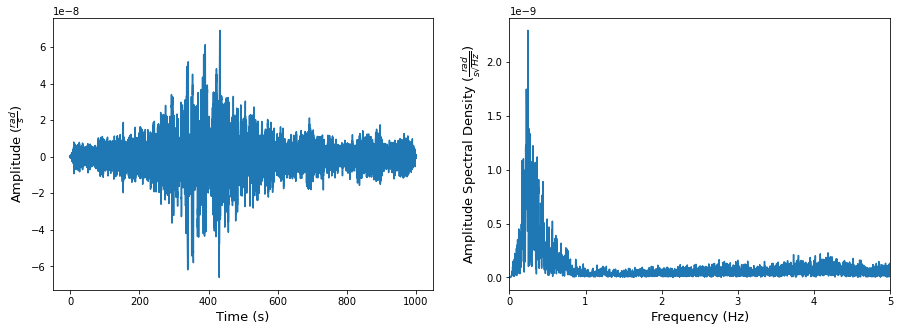

In [12]:
__makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=5); 

## Remove Median

Median is calulcated and removed since not relevant for instanenous frequency. 

In [13]:
if remove_median:
    med = np.median(synthetic_signal)
    synthetic_signal= synthetic_signal - np.median(synthetic_signal)


-553.35 0.193831772998


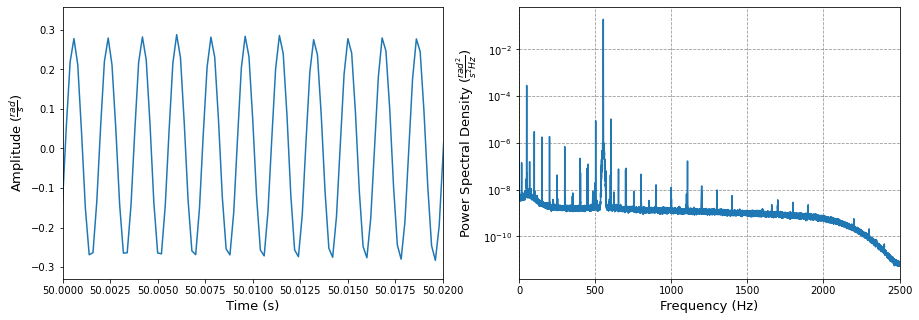

In [14]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=50, t2=50.02); 

## Notching

In [15]:
## test to remove 50 Hz harmonics with notch filter ... not desired effect

# for f in range(50,1000,50):
#     b, a = iirnotch(f, 30, sps)
#     synthetic_signal = filtfilt(b, a, synthetic_signal, method="pad")
    
# b, a = iirnotch(sgnc, 30, sps)
# synthetic_signal = filtfilt(b, a, synthetic_signal, method="pad")



In [16]:
# __makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps); 

## Taper

In [17]:
if taper:
    synthetic_signal = __tapering(synthetic_signal, win_type, perc)

-553.35 0.193831772998


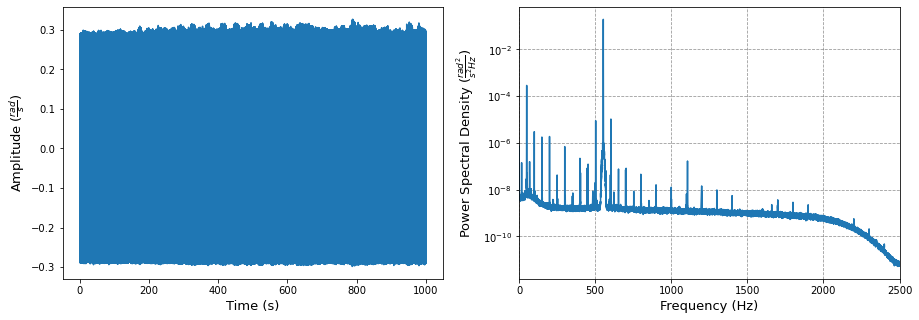

In [18]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps); 

## Bandpass 

In [19]:
if bandpass_pre:

    ## create butterworth bandpass
    b, a = butter(4, [f_lower_bp, f_upper_bp], 'bp', fs=sps)

    ## apply butterworth bandpass forward and backwards
    synthetic_signal = filtfilt(b, a, synthetic_signal, method="pad")


-553.35 0.193832370556


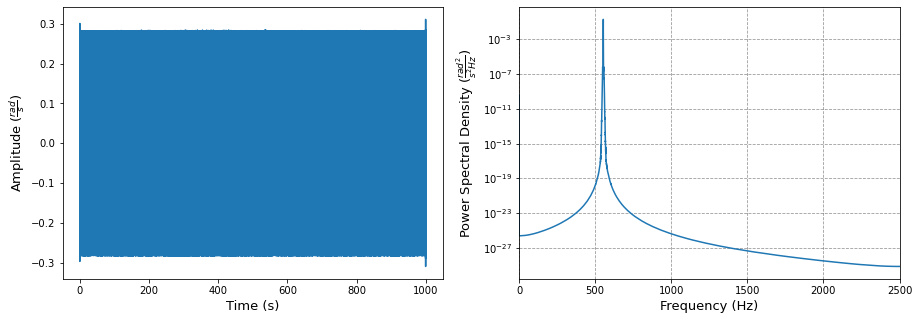

-553.35 0.193832370556


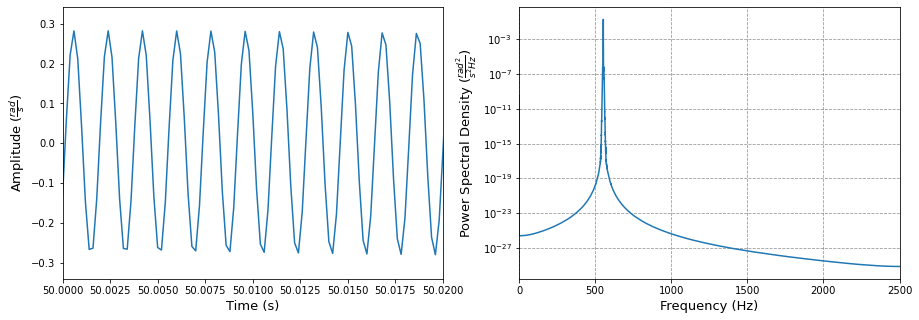

In [20]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps); 
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=50, t2=50.02); 

## Upsampling

Upsampling using a scipy method called 'resample()' which is based on the FFT

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample

In [21]:

def __interpolation_fft(trace, time, T, sps):
    
    from scipy.signal import resample
    from numpy import arange
    
    ## interpolate modeltrace to sps 
    l1 = trace.size
    
    trace = resample(trace, int(T*sps+1)) ## using FFT
#     time = resample(time, int(T*sps+1))    
    
    l2 = trace.size
    
    print(f"modeltrace is interpolated: {l1} samples --> {l2} samples")
#     print(f"time_modeltrace is interpolated: {l1} samples --> {l2} samples")

    time = np.arange(0, T+1/sps, 1/sps)

    return trace, time


Upsampling using a scipy method called 'resample_poly()' based on a fir filter. up / down = sampling rate, where down is estimated. 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample_poly.html

In [22]:

def __upsample_FIR(signal_in, sps, T, sampling_factor=2):
    
    from scipy.signal import upfirdn, resample_poly
    
    lower = 50
    upper = sampling_factor*lower
    
    signal_out = resample_poly(signal_in, upper, lower, padtype="line") ## using FIR filter
    
    ## adjsut sampling frequency with sampling factor
    sps_new = int(sps*sampling_factor)
    
    ## adjust time axis
    time_out = np.arange(0, T+1/sps_new, 1/sps_new)
    
    return signal_out[:-1], time_out


In [23]:

def __resample_signal_butter(signal_in, fs, up_factor, f_low=540, f_high=570, taper=False):

    ''' 
    up-samping of the simulated digital signal 
    
    sig_in   = input signal
    fs       = sampling frequency of digital signal
    fac      = sampling factor (2 = double)
    taper    = True/False , to either taper or not taper output
    
    '''
    ## add zeros to trace
    sig_out= np.zeros(len(signal_in)*up_factor)
    for h, i in enumerate(signal_in):
        sig_out[h] = i
        if up_factor > 2:
            for i in range(up_factor):
                sig_out[h] = 0
        else:
            sig_out[h] = 0

    

    ## butterworth bandpass filter
    b, a = butter(4, [f_low, f_high], btype='band', fs=fs)
       
    synthetic_signal = filtfilt(b, a, np.array(sig_out), method="gust")

    time_out = np.arange(0, len(sig_out)*fs, 1/fs)
    print(signal_in.size, sig_out.size)
    
    return np.array(sig_out), time_out
    

In [24]:
if upsampling:
    
    
#     synthetic_signal, timeline = __upsample_FIR(synthetic_signal, 
#                                                 sps, 
#                                                 T, 
#                                                 sampling_factor=upsampling_factor,
#                                                )

    synthetic_signal, timeline = __interpolation_fft(synthetic_signal, 
                                                     timeline, 
                                                     T, 
                                                     sps*upsampling_factor,
                                                    )
    
#     synthetic_signal, timeline = __resample_signal_butter(synthetic_signal, 
#                                                           sps, 
#                                                           upsampling_factor,
#                                                           f_low=540, 
#                                                           f_high=570,
#                                                          )
    
    
    ## adjust sampling rate
    sps = sps*upsampling_factor

-553.35 0.193832370556


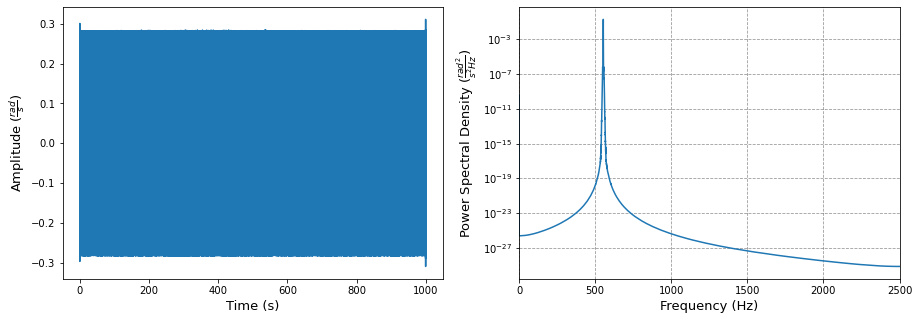

-553.35 0.193832370556


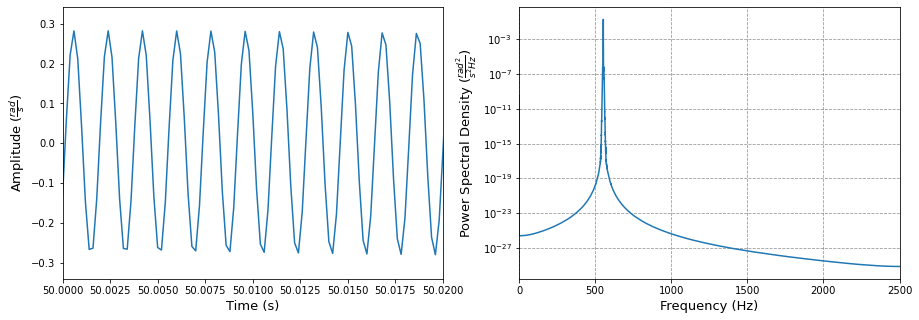

In [25]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps); 
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=50, t2=50.02); 

# Demodulation

In order to evaluate the demodulated signal it is compared to the kown synthetic signalthe. For this, the median is substracted and 1% of the edges are cut off. Then both, the orignal and the retrieved signal are normalized and a cross-correlation calculated.

In [26]:

def __hibert_filter(sig_in, time_in, fs):
    
    '''
    estimating the instantaneous frequency by using the formula of Jo
    
    sig_in    = input signal
    time_in   = input timeline
    fs        = sampling frequency of digital signal
    '''

    def __check_for_NaN(array):
        
        sum0, idx = 0, []
        for k, x in enumerate(array):
            if np.isnan(x):
                sum0 += 1
                idx.append(k)

        if sum0 != 0:
            print(sum0, f" nan found of {len(array)}")
    
        return(idx)
            
            
            
    ## calulcate hilbert transform
    hil0 = hilbert(sig_in)
    
    ## extract imaginary part of hilbert transform 
    hil = np.imag(hil0)
    
#     env = abs(hil)
#     hil = hil/max(env)
    
    ## calculate derivatives (second order central differences)
    d_hil = np.gradient(hil, edge_order=1)*fs
    d_sig = np.gradient(sig_in, edge_order=1)*fs
    
    
    ## check if nan are in derivative
#     idx = __check_for_NaN(d_hil)
    
    
#     delta_f_full = (sig_in * d_hil - d_sig * hil) / (2*np.pi*np.sqrt(sig_in**2 + hil**2))
    
    ## without sqrt as found on Wikipedia
    delta_f_full = (sig_in * d_hil - d_sig * hil) / (2*np.pi*(sig_in**2 + hil**2))


    ## extract real part
    delta_f = np.real(delta_f_full)
    
    
    ## instert nan value for time zero (exluded bevause of np.diff() ) 
    idx = __check_for_NaN(delta_f)
    
    for l in idx:
        delta_f[l] = 0.0

    
    return time_in, delta_f


In [27]:

def __demodulate(x, y, Twindow, sps):

    window_size = int(Twindow * sps)

    stepsize = int(window_size/2) 

    out1, out2 = np.array([]), np.array([])
    for i in tqdm(range(0,len(x), stepsize)):

        if int(i+window_size) > len(x):
            print(f"break for {i/sps}")
            break

        win1 = x[i:int(i+window_size)]
        win2 = y[i:int(i+window_size)]


        t, sig = __hibert_filter(win1, win2, sps)

    #     plt.plot(t[int(stepsize/2):window_size-int(stepsize/2)], sig[int(stepsize/2):window_size-int(stepsize/2)])
    #     plt.show();

        out1 = np.append(out1, sig[int(stepsize/2):window_size-int(stepsize/2)])
        out2 = np.append(out2, t[int(stepsize/2):window_size-int(stepsize/2)])
    #     plt.plot(out2,out1)

    return out1, out2


In [28]:

# Twindow = 100 # seconds

demod_signal, time_demod_signal = __demodulate(synthetic_signal, timeline, Twindow, sps)


time_demod_signal.size, demod_signal.size

 82%|████████▏ | 9/11 [00:13<00:03,  1.53s/it]

break for 900.0


(4500000, 4500000)

In [29]:
# time_demod_signal, demod_signal = __hibert_filter(synthetic_signal, timeline, sps)

# demod_signal = demod_signal - np.median(demod_signal)

# num = int(10*5000)
# demod_signal[:num] = 0
# demod_signal[-num:] = 0

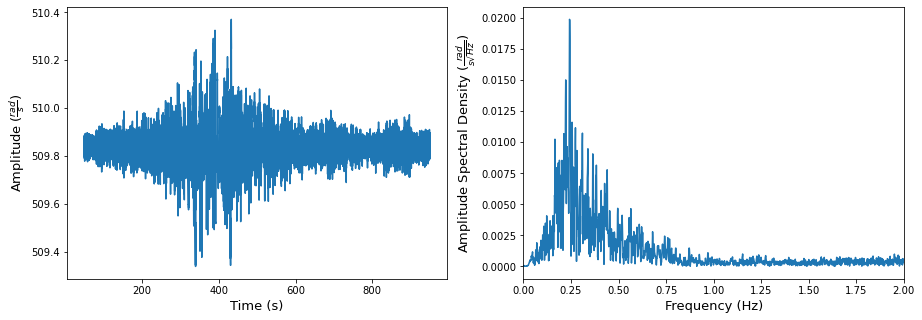

In [30]:
__makeplot_trace_and_spectrum(demod_signal, time_demod_signal, fmax=2); 

### Remove Offset

In [31]:
print(f"theo. Sagnac Frequencs: {sgnc} Hz")
print(f"Median Demodulated Signal: {np.median(demod_signal)}")


# demod_signal = demod_signal - sgnc
demod_signal = demod_signal - np.median(demod_signal)

theo. Sagnac Frequencs: 553.6690497710365 Hz
Median Demodulated Signal: 509.8372070525518


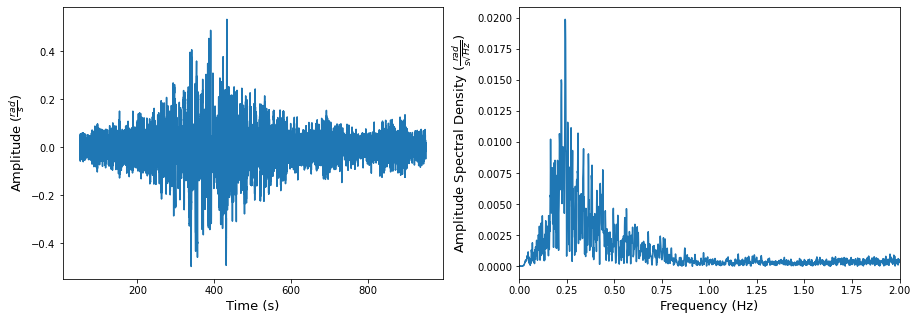

In [32]:
# __makeplot_trace_and_psd(demod_signal, time_demod_signal, fmax=0.5*sps, t1=100, t2=101); 
__makeplot_trace_and_spectrum(demod_signal, time_demod_signal, fmax=2.0); 

## Taper

In [33]:
# demod_signal = __tapering(demod_signal, "flanks", 1)

In [34]:
# __makeplot_trace_and_psd(demod_signal, time_demod_signal, fmax=0.5*sps); 

### Lowpass

In [35]:
if lowpass_post:
    
    f_upper_lp = 200

    ## create digital lowpass filter, which is applied forwards and backwards
    b, a = butter(8, f_upper_lp, 'lp', fs=sps)
    demod_signal = filtfilt(b, a, demod_signal, method="pad")
    
    ## apply lowpass filter of obspy (using fft)
#     tmp = Trace(demod_signal)
#     tmp.stats.delta = 1/sps
#     tmp.filter('lowpass', freq=f_upper_lp, corners=8, zerophase=True)
#     demod_signal = tmp.data

demod_signal.size, time_demod_signal.size

(4500000, 4500000)

-0.250000000001 0.0162547827671


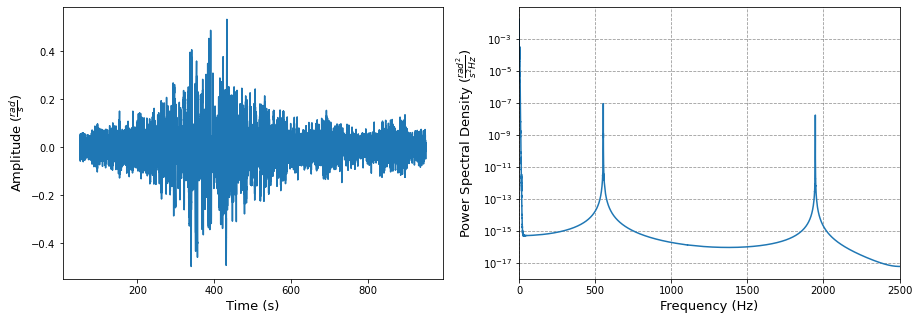

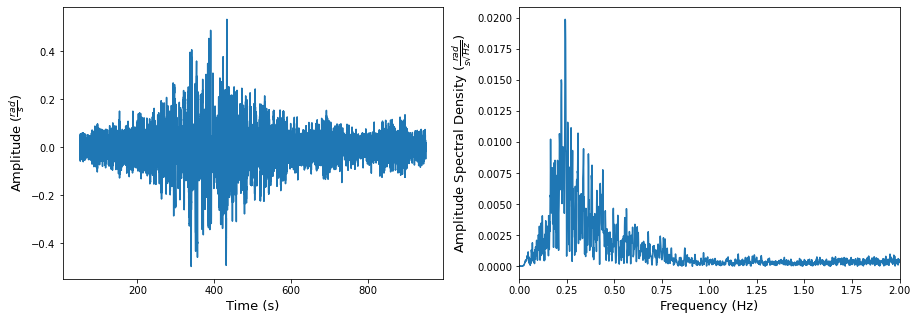

In [36]:
__makeplot_trace_and_psd(demod_signal, time_demod_signal, fmax=0.5*sps); 
__makeplot_trace_and_spectrum(demod_signal, time_demod_signal, fmax=2.0); 

### Downsampling 

In [37]:

def __downsample(signal_in, sps, ds_factor=2):

    
    ## downsample using a FIR filter
    signal_out = decimate(signal_in, ds_factor, n=None, ftype='fir', axis=-1, zero_phase=True)


    ## adjust sampling frequency
    sps = int(sps/ds_factor)

    ## adjust time axis
    time_out = np.arange(signal_out.size)/sps

    return signal_out, time_out, sps


In [38]:
if upsampling:

    
    downsampling_factor = upsampling_factor

    sps0 = sps ## prevent overwriting
    demod_signal, time_demod_signal, sps = __downsample(demod_signal, sps0, ds_factor=downsampling_factor)
#     modeltrace, time_modeltrace, sps = __downsample(modeltrace, sps0, ds_factor=downsampling_factor)
    

    ## adjust index after resampling
#     index1=int(index1/downsampling_factor)
#     index2=int(index2/downsampling_factor)
    

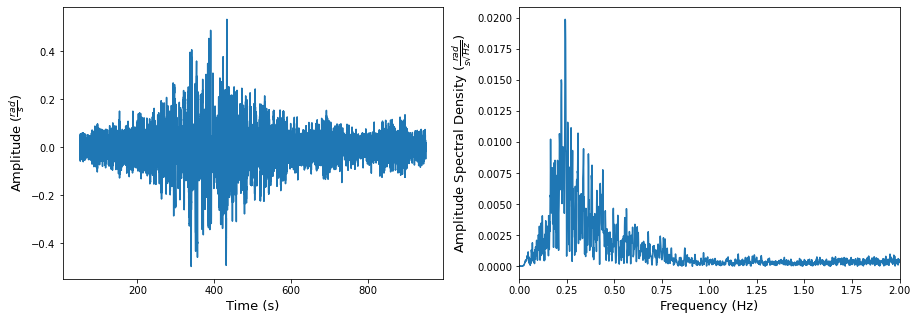

In [39]:
__makeplot_trace_and_spectrum(demod_signal, time_demod_signal, fmax=2.0); 

### Normalize

In [40]:
## apply conversion counts -> volt of obsidian digitizer
demod_signal *= 0.59604645e-6

In [41]:
max(demod_signal), max(modeltrace)

(3.1792732361807329e-07, 6.919762724633459e-08)

In [42]:
if normalize:
    demod_signal = __normalize(demod_signal)
    modeltrace   = __normalize(modeltrace)


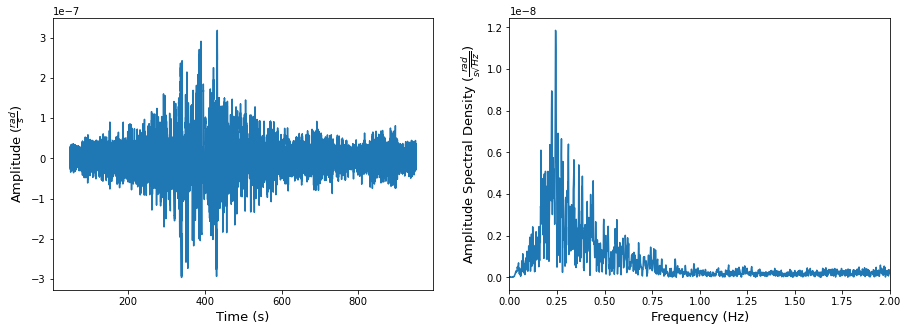

In [43]:
# __makeplot_trace_and_psd(demod_signal, time_demod_signal, fmax=0.5*sps, t1=100, t2=101); 
__makeplot_trace_and_spectrum(demod_signal, time_demod_signal, fmax=2.0); 

## shift demod signal one sample left.. do not know why!! 

In [44]:
print(demod_signal.size, time_demod_signal.size)
demod_signal = demod_signal[1:]

print(demod_signal.size, time_demod_signal.size)
demod_signal= np.append(demod_signal, 0)

print(demod_signal.size, time_demod_signal.size)

4500000 4500000
4499999 4500000
4500000 4500000


### Padding Edges

In [45]:
## samples from left and right to be ignored due to dynamic demodulation
index1 = int(time_demod_signal[0]*sps)

if upsampling:
    index2 = int(int(T-time_demod_signal[-1])*sps)
else:
    index2 = int(int(T-time_demod_signal[-1])*sps)

## padding demodulated signal at the edges
demod_signal = np.pad(demod_signal, (index1, index2), constant_values=(0, 0))

## adjust time axis
time_demod_signal = np.arange(len(demod_signal))/sps



time_demod_signal.size, demod_signal.size, index1, index2

(5000000, 5000000, 250000, 250000)

### Final Plotting

In [46]:
if lowpass_post:
    cut1 = int(index1)
    cut2 = int(len(demod_signal)-index2)
else:
    cut1 = int(index1)
    cut2 = int(len(demod_signal)-index2)   
    

cut1, cut2

(250000, 4750000)

### Cross-Correlation

In [47]:
cross_corr = correlate(demod_signal[cut1:cut2], modeltrace[cut1:cut2], mode='same')

cross_corr_lags = np.arange(-cross_corr.size//2+1,cross_corr.size//2+1,1)

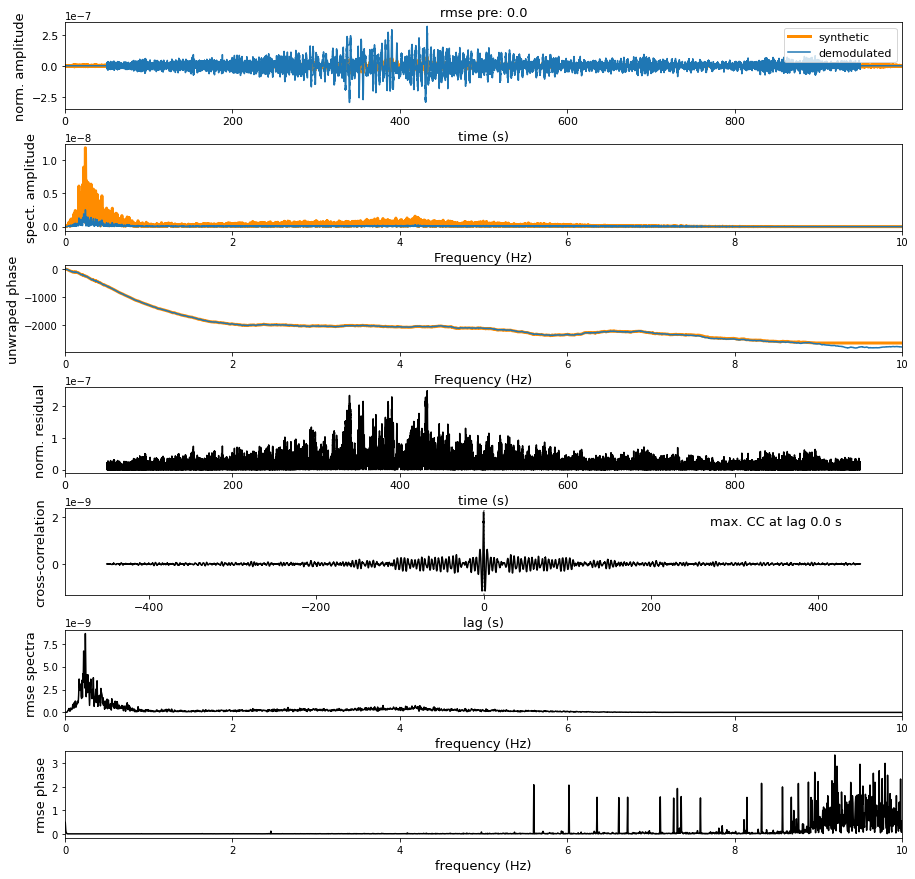

In [48]:
fig = __makeplot_demodulation_quality(time_modeltrace, 
                                      modeltrace, 
                                      time_demod_signal,
                                      demod_signal,
                                      cross_corr,
                                      cross_corr_lags,
                                      sps,
                                      cut1,
                                      cut2,
                                      fmax=10
                                     );

In [49]:
# idx1 = np.where(timeline == time_demod_signal[0])[0][0]
# idx2 = np.where(timeline == time_demod_signal[-1])[0][0]

# modeltrace = modeltrace[idx1:idx2]
# time_modeltrace = time_modeltrace[idx1:idx2]

In [50]:

# def __makeplot_evaluation():

#     from andbro__fft import __fft

#     asd_demod, ff_demod, phase_demod = __fft(demod_signal, 1/sps, window=None, normalize=None)
#     asd_model, ff_model, phase_model = __fft(modeltrace, 1/sps, window=None, normalize=None)


    
    
#     ## __________________________________________________________

#     fig, ax = plt.subplots(4,1, figsize=(15,10))

#     fig.subplots_adjust(hspace = 0.4)
    
#     font = 13

#     ax[0].plot(time_modeltrace, modeltrace, color='k', lw=2)
# #     ax[0].plot(time_demod_signal[1000:-1000], demod_signal[1000:-1000], color='green', lw=2)
#     ax[0].plot(time_demod_signal, demod_signal, color='green', lw=2)

    
#     ax[1].plot(ff_model, asd_model, color='k')
#     ax[1].plot(ff_demod, asd_demod, color='green')

    
#     ax[2].plot(ff_model, np.unwrap(phase_model), color='k')
#     ax[2].plot(ff_demod, np.unwrap(phase_demod), color='green')

    
    
#     # ax[3].plot(time_modeltrace, modeltrace, color='k')
#     # ax[3].plot(time_demod_signal, demod_signal, color='darkred')
#     ax[3].axvline(0.0, color="grey", ls=":")
#     ax[3].plot(cross_corr_lags/sps, cross_corr,'k')

    
#     ax[0].set_xlabel("Frequency (Hz)", fontsize=font)
#     ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
#     ax[2].set_xlabel("Frequency (Hz)", fontsize=font)
#     ax[3].set_xlabel('lag (s)', fontsize=font)
    
#     ax[0].set_ylabel('norm. rot. rate', fontsize=font)
#     ax[1].set_ylabel(r'spect. amplitude \n (rad/s $\sqrt{Hz}$)', fontsize=font)
#     ax[2].set_ylabel('unwraped phase', fontsize=font)    
#     ax[3].set_ylabel('cross-correlation', fontsize=font)
    
#     ax[3].tick_params(axis='both', labelsize=font-2)

#     x0 = 0.6*max(cross_corr_lags)/sps
#     y0 = 0.75*max(cross_corr)

#     ax[3].text(x0, y0, f'max. CC at lag {cross_corr_lags[abs(cross_corr).argmax()]/sps} s', fontsize=font)
# #     ax[3].text(x0, y0, f'max. CC at lag {cross_corr_lags[abs(cross_corr).argmax()]}', fontsize=font)


#     ax[1].set_xlim(0,0.2)

#     for i in range(4):
#         ax[i].grid(ls='--',zorder=0)

# __makeplot_evaluation()    

### Save Plot

In [51]:
# pname = f"plot_T{int(T)}_fs{int(sps)}_{signal}_{name}
# _{Twindow}.png"

# fig.savefig(
#             f"plots/cases/{pname}",
#             dpi=300, facecolor='w', 
#             edgecolor='w',
#             orientation='portrait', 
#             format="png",
#             transparent=False, 
#             bbox_inches="tight", 
#             pad_inches=0.2,
#            )


## Tests